# Graph Classification - Synthetic Data
## Experiment results

In [1]:
import comet_ml
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

sns.set_style('white')

In [42]:
models = ['gcn', 'sage', 'gin']
types = ['base', 'transfer']

p_tags = ['p=0.1', 'p=0.5', 'p=0.9']
n_tags = ['n=10', 'n=30', 'n=50_']
std_tags = ['std=0.1', 'std=1', 'std=5.0', 'std=10.0']

default_p = 'p=0.5'
default_n = 'n=30'
default_std = 'std=1'

***
### Gathering results
Run the cell below to gather all the experiment results from  Comet.ml.

In [76]:
comet_api = comet_ml.api.API()
experiments = comet_api.get('graph-net-experiments/graph-classification-synthetic')

# gets dict with experiment_id : set of tags
experiments_with_tags = {
    exp.id: frozenset(exp.get_tags())
    for exp in experiments
}

tags = set(experiments_with_tags.values()) # gets unique tags
experiments_by_tags = { tag: [] for tag in tags } 

# experiments_by_tags: dict with all experiment ids under unique tags
for exp, exp_tags in experiments_with_tags.items():
    experiments_by_tags[exp_tags].append(exp)

In [44]:
def get_experiment_curves(exp_tag):
    losses = []
    accuracies = []

    for exp_id in experiments_by_tags[exp_tag]:
        loss = np.array([  float(step['metricValue'])
                        for step in comet_api.get_experiment_by_id(exp_id).get_metrics('train_loss')])
        acc   = np.array([  float(step['metricValue']) 
                        for step in comet_api.get_experiment_by_id(exp_id).get_metrics('accuracy')])

        losses.append(loss)
        accuracies.append(acc)
        
    losses = np.stack(losses)
    accuracies = np.stack(accuracies)

    exp_dict = {
        'losses': losses,
        'accuracies': accuracies
    }

    return exp_dict


def get_experiment_curves_by_tags(exp_tags):
    return {
        tag: get_experiment_curves(tag) for tag in exp_tags
    }

In [73]:
def check_exp_len(tag):
    for exp_id in experiments_by_tags[tag]:
        acc_len = len(comet_api.get_experiment_by_id(exp_id).get_metrics('accuracy'))
        loss_len = len(comet_api.get_experiment_by_id(exp_id).get_metrics('train_loss'))

        if acc_len < 200 or loss_len < 200:
            print(exp_id)
            print(acc_len)
            print(loss_len)
            print()


def check_exp_len_by_tags(exp_tags, label):
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
    print(label)

    for model in models:
        print(model)

        for tag in exp_tags[model]:
            print('-----------------------------------')
            print(tag)
            check_exp_len(tag)
            print()

In [84]:
# BASE EXPERIMENTS
base_experiment_tags = [
    frozenset({'base', model }) for model in models
]

base_experiments = get_experiment_curves_by_tags(base_experiment_tags)


# VARYING p PARAMETER
p_param_tags = {
    model:
    [
        frozenset({'N=50', 'n=30', tag, 'std=1', model, 'transfer'}) 
        for tag in p_tags
    ]

    for model in models
}

p_param_experiments = { 
    model: 
    get_experiment_curves_by_tags(p_param_tags[model]) 
    
    for model in models 
}


# VARYING n PARAMETER
n_param_tags = {
    model:
    [
        frozenset({'N=50', tag, 'p=0.5', 'std=1', model, 'transfer'}) 
        for tag in n_tags
    ]

    for model in models
}

n_param_experiments = { 
    model: 
    get_experiment_curves_by_tags(n_param_tags[model]) 
    
    for model in models
}


# VARYING std PARAMETER
std_param_tags = {
    model:
    [
        frozenset({'N=50', 'n=30', 'p=0.5', tag, model, 'transfer'}) 
        for tag in std_tags
    ]

    for model in models
}

std_param_experiments = { 
    model: 
    get_experiment_curves_by_tags(std_param_tags[model])
    
    for model in models
}

In [81]:
# check_exp_len_by_tags(base_experiment_tags, 'Base')
check_exp_len_by_tags(p_param_tags, 'p Parameter')
check_exp_len_by_tags(n_param_tags, 'n Parameter')
check_exp_len_by_tags(std_param_tags, 'std Parameter')

In [88]:
torch.save({
    'base': base_experiments,
    'p': p_param_experiments,
    'n': n_param_experiments,
    'std': std_param_experiments
}, 
'experiment_result_dict')

### Plotting results
Alternatively, use saved results from `experiment_result_dict`.

In [89]:
experiment_results = torch.load('experiment_result_dict')

In [92]:
experiment_results['p']['gcn'].keys()

dict_keys([frozenset({'std=1', 'transfer', 'N=50', 'gcn', 'n=30', 'p=0.1'}), frozenset({'std=1', 'transfer', 'N=50', 'gcn', 'p=0.5', 'n=30'}), frozenset({'std=1', 'transfer', 'p=0.9', 'N=50', 'gcn', 'n=30'})])

In [98]:
experiment_results['base']

In [103]:
experiment_results['base'][frozenset({'base', model})]['accuracies'].mean(axis=0)

array([0.20635789, 0.23427368, 0.23461053, 0.23469474, 0.2304    ,
       0.23044211, 0.23014737, 0.21818947, 0.20143158, 0.20416842,
       0.19052632, 0.16568421, 0.16101053, 0.16088421, 0.16909474,
       0.18282105, 0.19145263, 0.17178947, 0.21044211, 0.21781053,
       0.20151579, 0.21490526, 0.22496842, 0.23890526, 0.23802105,
       0.24547368, 0.23309474, 0.23065263, 0.22648421, 0.23115789,
       0.24901053, 0.26597895, 0.29136842, 0.26176842, 0.26197895,
       0.24088421, 0.23928421, 0.25524211, 0.23284211, 0.24404211,
       0.26408421, 0.22774737, 0.2176    , 0.23797895, 0.24543158,
       0.24463158, 0.20808421, 0.21267368, 0.19776842, 0.1976    ,
       0.20665263, 0.22715789, 0.24964211, 0.26534737, 0.23823158,
       0.22303158, 0.19688421, 0.22366316, 0.23465263, 0.24812632,
       0.25073684, 0.2312    , 0.22071579, 0.23814737, 0.24821053,
       0.23246316, 0.23263158, 0.21191579, 0.2144    , 0.19705263,
       0.18425263, 0.18349474, 0.19772632, 0.19195789, 0.19722

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


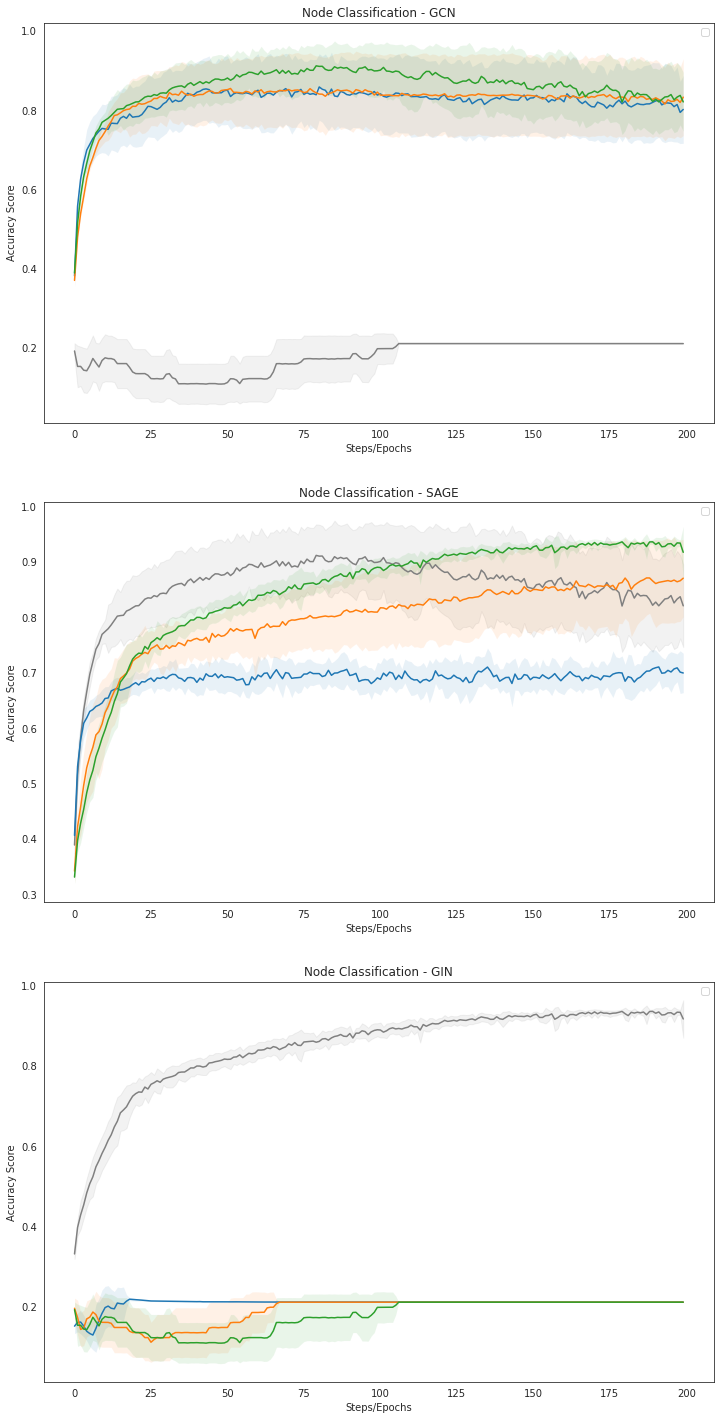

In [109]:
# legend_dict = {
#     'base': 'Random Seed',
#     'configuration_1': 'Transferred from Configuration 1',
#     'configuration_2': 'Transferred from Configuration 2',
#     'configuration_3': 'Transferred from Configuration 3'}
# colours = {'base': 'dodgerblue', 'configuration_1': 'blueviolet', 'configuration_2': 'limegreen', 'configuration_3': 'orangered',}

plt.figure(figsize=(12, 25))

for i, model in enumerate(models):
    plt.subplot(3,1,i+1)

    # base experiment
    base_acc = experiment_results['base'][frozenset({'base', model})]['accuracies']
    base_acc_mean = base_acc.mean(axis=0)
    base_acc_std = (base_acc_mean + base_acc.std(axis=0), base_acc_mean - base_acc.std(axis=0))

    plt.plot(acc.mean(axis=0), color='grey')
    plt.fill_between(np.arange(len(acc_mean)), acc_std[0], acc_std[1], alpha=0.1, color='grey')

    # transfer experiments
    for tag, result in experiment_results['p'][model].items():
        acc = result['accuracies']
        acc_mean = acc.mean(axis=0)
        acc_std = (acc_mean + acc.std(axis=0), acc_mean - acc.std(axis=0))

        plt.plot(acc.mean(axis=0))
        plt.fill_between(np.arange(len(acc_mean)), acc_std[0], acc_std[1], alpha=0.1)
    
    plt.xlabel('Steps/Epochs')
    plt.ylabel('Accuracy Score')
    plt.title('Node Classification - ' + model.upper())
    plt.legend()

In [ ]:
# colours = {'transfer': 'blueviolet', 'self-transfer': 'limegreen', 'self-transfer-new-layer': 'orangered'}
markers = {'gcn': 'o', 'sage': 'P', 'gin': 'D'}

plt.figure(figsize=(12,8))

for model in models:
    base = experiment_results[frozenset({model, 'base'})]['accuracies'][:, 0].mean()
    transfer = experiment_results[frozenset({model, 'transfer'})]['accuracies'][:, 0].mean()
    self_transfer = experiment_results[frozenset({model, 'self-transfer'})]['accuracies'][:, 0].mean()
    self_transfer_new_layer = experiment_results[frozenset({model, 'self-transfer-new-layer'})]['accuracies'][:, 0].mean()

    plt.scatter(base, transfer, marker=markers[model], s=50,
                label='{} Arxiv Transfer'.format(model.upper()), color=colours['transfer'])
    plt.scatter(base, self_transfer, marker=markers[model], s=50,
                label='{} Self-Transfer'.format(model.upper()), color=colours['self-transfer'])
    plt.scatter(base, self_transfer_new_layer, marker=markers[model], s=50,
                label='{} Self-Transfer'.format(model.upper()), color=colours['self-transfer-new-layer'])

plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='grey', lw=1)

axes = plt.gca()
axes.set_xlim([0, 0.3])
axes.set_ylim([0, 0.3])

plt.title('Transfer vs. Random initialisation - Jumpstart')
plt.xlabel('Random seed Accuracy')
plt.ylabel('Transfer Accuracy')
plt.legend();

KeyError: frozenset({'gcn', 'transfer'})

<Figure size 864x576 with 0 Axes>

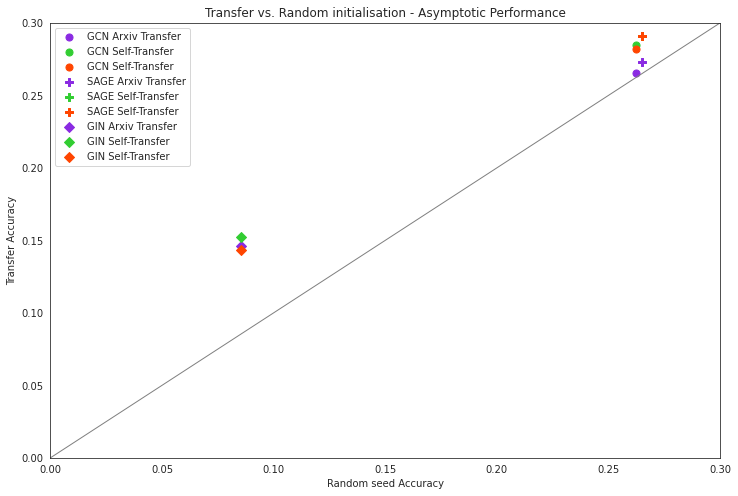

In [ ]:
colours = {'transfer': 'blueviolet', 'self-transfer': 'limegreen', 'self-transfer-new-layer': 'orangered'}
markers = {'gcn': 'o', 'sage': 'P', 'gin': 'D'}

plt.figure(figsize=(12,8))

for model in models:
    base = experiment_results[frozenset({model, 'base'})]['accuracies'][:, 199].mean()
    transfer = experiment_results[frozenset({model, 'transfer'})]['accuracies'][:, 199].mean()
    self_transfer = experiment_results[frozenset({model, 'self-transfer'})]['accuracies'][:, 199].mean()
    self_transfer_new_layer = experiment_results[frozenset({model, 'self-transfer-new-layer'})]['accuracies'][:, 199].mean()

    plt.scatter(base, transfer, marker=markers[model], s=50,
                label='{} Arxiv Transfer'.format(model.upper()), color=colours['transfer'])
    plt.scatter(base, self_transfer, marker=markers[model], s=50,
                label='{} Self-Transfer'.format(model.upper()), color=colours['self-transfer'])
    plt.scatter(base, self_transfer_new_layer, marker=markers[model], s=50,
                label='{} Self-Transfer'.format(model.upper()), color=colours['self-transfer-new-layer'])

plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='grey', lw=1)

axes = plt.gca()
axes.set_xlim([0, 0.3])
axes.set_ylim([0, 0.3])

plt.title('Transfer vs. Random initialisation - Asymptotic Performance')
plt.xlabel('Random seed Accuracy')
plt.ylabel('Transfer Accuracy')
plt.legend();

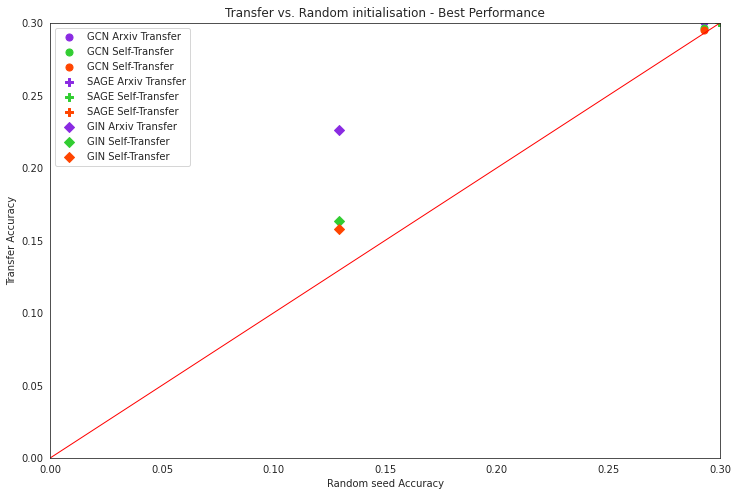

In [ ]:
colours = {'transfer': 'blueviolet', 'self-transfer': 'limegreen', 'self-transfer-new-layer': 'orangered'}
markers = {'gcn': 'o', 'sage': 'P', 'gin': 'D'}

plt.figure(figsize=(12,8))

for model in models:
    base = experiment_results[frozenset({model, 'base'})]['accuracies'].mean(axis=0).max()
    transfer = experiment_results[frozenset({model, 'transfer'})]['accuracies'].mean(axis=0).max()
    self_transfer = experiment_results[frozenset({model, 'self-transfer'})]['accuracies'].mean(axis=0).max()
    self_transfer_new_layer = experiment_results[frozenset({model, 'self-transfer-new-layer'})]['accuracies'].mean(axis=0).max()

    plt.scatter(base, transfer, marker=markers[model], s=50,
                label='{} Arxiv Transfer'.format(model.upper()), color=colours['transfer'])
    plt.scatter(base, self_transfer, marker=markers[model], s=50,
                label='{} Self-Transfer'.format(model.upper()), color=colours['self-transfer'])
    plt.scatter(base, self_transfer_new_layer, marker=markers[model], s=50,
                label='{} Self-Transfer'.format(model.upper()), color=colours['self-transfer-new-layer'])

plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='red', lw=1)

axes = plt.gca()
axes.set_xlim([0, 0.3])
axes.set_ylim([0, 0.3])

plt.title('Transfer vs. Random initialisation - Best Performance')
plt.xlabel('Random seed Accuracy')
plt.ylabel('Transfer Accuracy')
plt.legend();